# Decision tree ja Random forest Titanic-datalla

![titanic](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/RMS_Titanic_3.jpg/266px-RMS_Titanic_3.jpg)

Tavoitteena on kouluttaa decision tree ja random forest mallit ennustamaan, onko Titanic-matkustaja todennäköisemmin selviytyjä vai uhri.

[Dataset description](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active)

In [42]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np


Datasetti löytyy Seaborn-kirjastosta ja katsotaan ensimmäiset rivit.

sns.load_dataset('titanic')

In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Katsotaan datasetin info. Onko NaN-arvoja

In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Täytetään puuttuvat arvot haluttuihin sarakkeihin, eli mitä aiotaan käyttää kouluttamisessa.

In [9]:
# age embarked
titanic['age'].fillna(titanic['age'].median(), inplace=True)
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace=True)

titanic.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


C:\Users\emilh\AppData\Local\Temp\ipykernel_3576\813696173.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic['age'].fillna(titanic['age'].median(), inplace=True)


Muutetaan sukupuoli ja embarked numeerisiksi

[scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [ ]:
le = LabelEncoder()
titanic['sex'] = le.fit_transform(titanic['sex'])
titanic['embarked'] = le.fit_transform(titanic['embarked'])

#titanic.head()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    int64   
 3   age          891 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     891 non-null    int64   
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(6), object(3)
memory usage: 80.7+ KB


Valitaan koulutuksessa käytettävät ominaisuudet/sarakkeet.

Jaetaan myös kohdeluokka omaan muuttujaan.

In [14]:
X_features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
y_features = ['survived']

X = titanic[X_features]
y = titanic[y_features]

Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision tree

Luodaan DecisionTreeClassifier ja koulutetaan malli

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
decision_tree.fit(X_train, y_train)

# max_depth = None tarkkuus 79% ja max_depth=3 tarkkuus 79%

DecisionTreeClassifier(max_depth=3, random_state=42)

Ennustetaan testidatalla ja lasketaan ennusteiden sekä oikeiden tulosten avulla tarkkuus.

In [ ]:
y_pred_dt = decision_tree.predict(X_test)

# Tarkkuus = oikein ennustetut tapaukset / kaikilla tapauksilla
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_accuracy


0.7988826815642458

Visualisoidaan puu

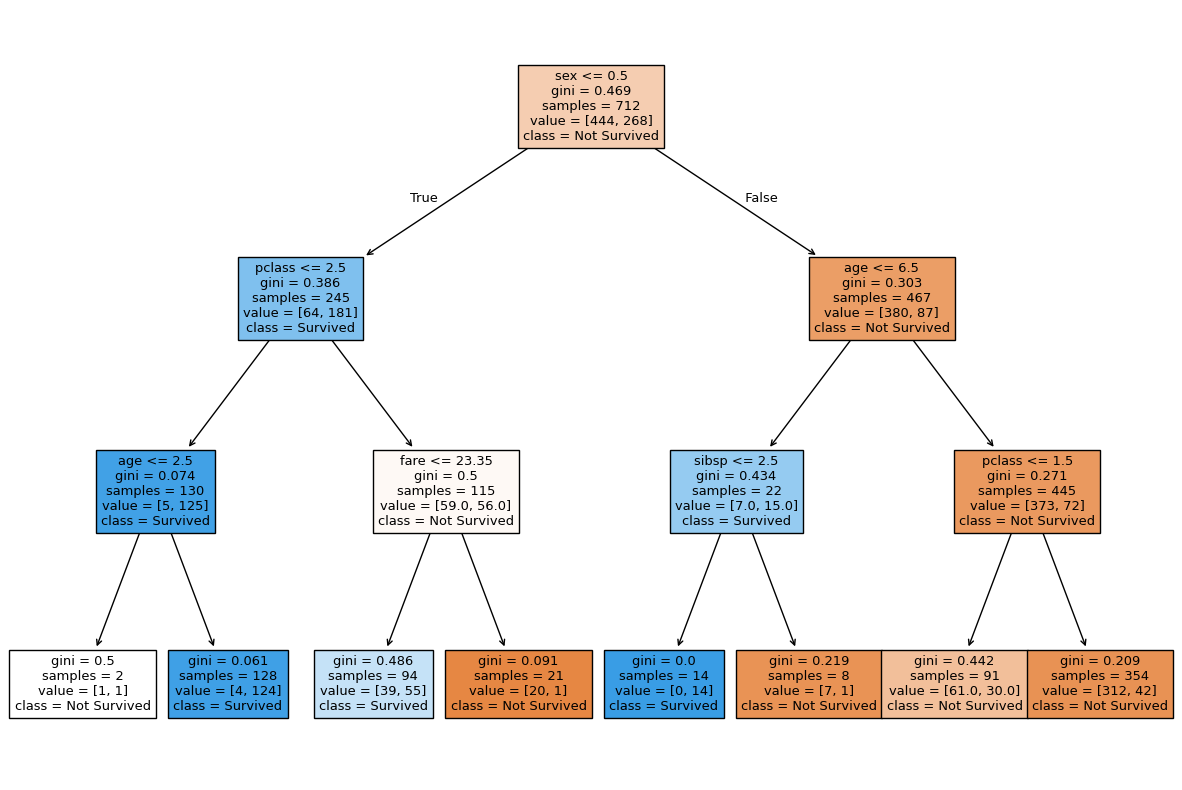

In [32]:
plt.figure(figsize=(15, 10))
plot_tree(decision_tree, feature_names=X_features, class_names=['Not Survived', 'Survived'], filled=True)
plt.show()

## Random Forest

Luodaan RandomForestClassifier ja koulutetaan malli

In [39]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)

random_forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=3, random_state=42)

Ennustetaan testidatalla ja lasketaan ennusteiden sekä oikeiden tulosten avulla tarkkuus.

In [40]:
y_pred_rf = random_forest.predict(X_test)


rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_accuracy

0.8100558659217877

Valitaan yksi päätöspuu satunnaismetsästä (esim. ensimmäinen puu) ja visualisoidaan valittu päätöspuu.

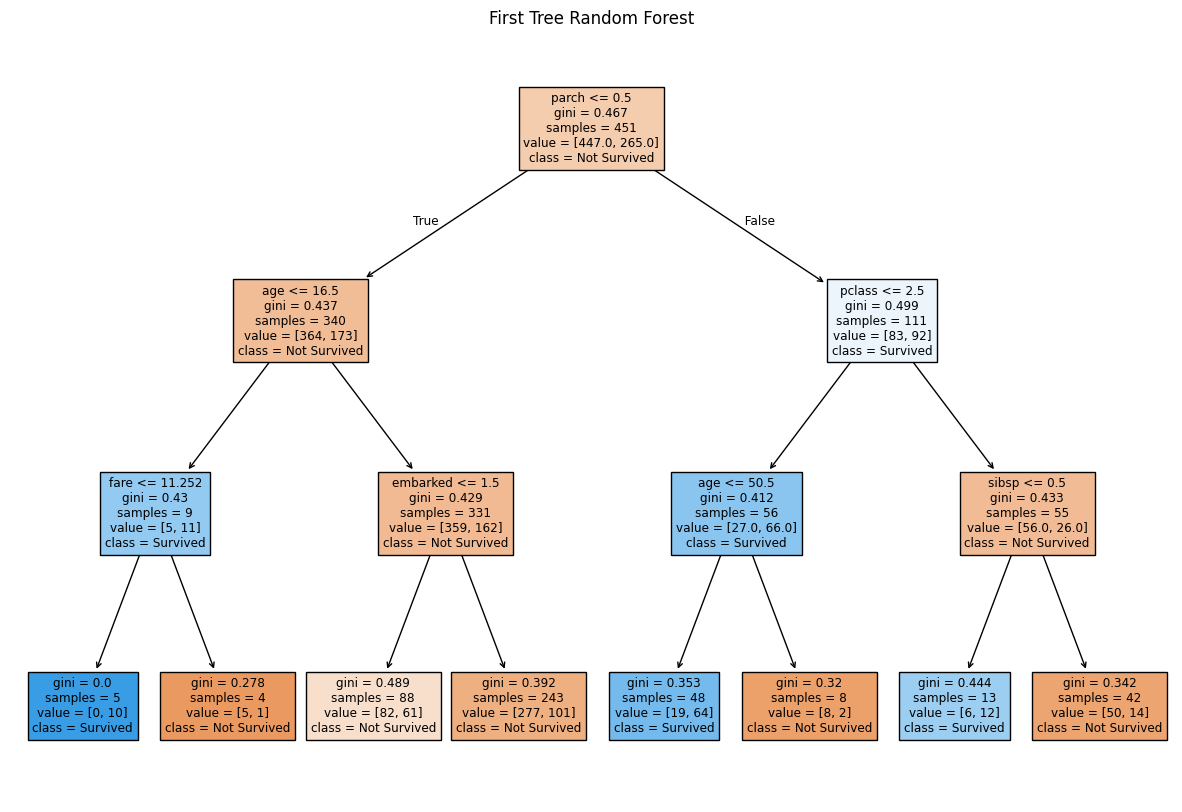

In [41]:
first_t = random_forest.estimators_[0]

plt.figure(figsize=(15, 10))
plot_tree(first_t, feature_names=X_features, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("First Tree Random Forest")
plt.show()

Satunnaismetsän yksi hyödyllinen ominaisuus on sen kyky arvioida, mitkä ominaisuudet ovat tärkeimpiä ennusteen kannalta. Voit visualisoida ominaisuuksien tärkeyden näin:

Pohjautuu: [Feature importances with a forest of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)


"A standard deviation (or σ) is a measure of how dispersed the data is in relation to the mean".
[source](https://www.nlm.nih.gov/oet/ed/stats/02-900.html#:~:text=A%20standard%20deviation%20(or%20%CF%83,data%20are%20more%20spread%20out)

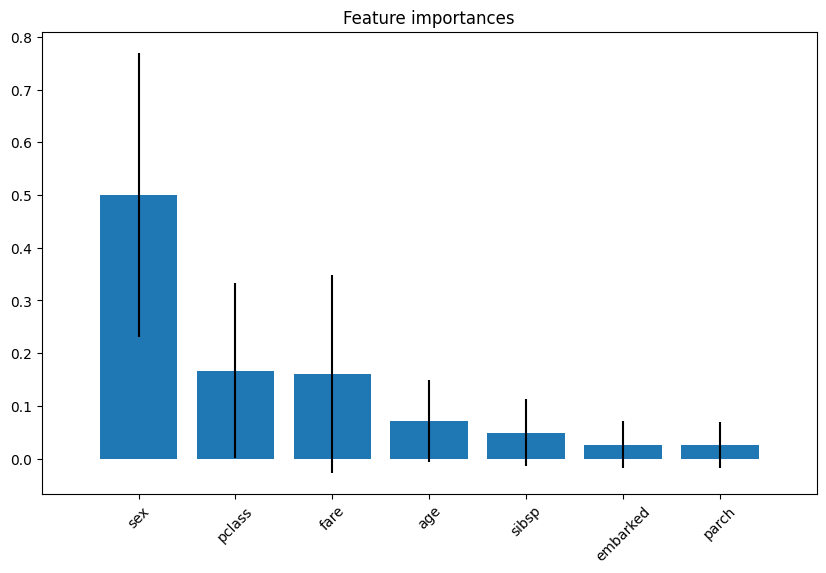

In [44]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_features[i] for i in indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()